<a href="https://colab.research.google.com/github/pritika-vig/modeling-adrs/blob/main/feature_engineering/explore_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install and import packages
!pip install google-cloud-bigquery pandas tqdm --quiet

In [ ]:

from google.cloud import bigquery
import pandas as pd
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Authenticate with Google Cloud (interactive in Colab)
from google.colab import auth
auth.authenticate_user()
drive.mount('/content/drive')

# Initialize BigQuery client
project_id = "mit-mlhc-class-450518"   # Replace with your GCP project ID
client = bigquery.Client(project=project_id)

# Define ADR ICD-9 codes (including poisoning and adverse reactions)
ADR_ICD9_CODES = set([
    '9950', '9952',
    'E850', 'E851', 'E852', 'E853', 'E854', 'E855', 'E856', 'E858', 'E859',
    'E930', 'E931', 'E932', 'E933', 'E934', 'E935', 'E936', 'E937', 'E938', 'E939',
    'E940', 'E941', 'E942', 'E943', 'E944', 'E945', 'E946', 'E947', 'E948', 'E949'
])


Mounted at /content/drive


In [ ]:
# Query ICU stays longer than 3 full days
icu_stays = client.query("""
SELECT
  i.subject_id,
  i.hadm_id,
  i.icustay_id,
  i.intime,
  i.outtime,
  p.gender,
  TIMESTAMP_DIFF(a.admittime, p.dob, YEAR) AS age,
  a.ethnicity,
  a.admission_type
FROM `physionet-data.mimiciii_clinical.icustays` i
JOIN `physionet-data.mimiciii_clinical.patients` p
  ON i.subject_id = p.subject_id
JOIN `physionet-data.mimiciii_clinical.admissions` a
  ON i.hadm_id = a.hadm_id
WHERE DATETIME_DIFF(i.outtime, i.intime, DAY) >= 4
""").to_dataframe()

# Fetch and merge ICD diagnoses and procedures
diagnoses = client.query("""
SELECT subject_id, hadm_id, icd9_code
FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
""").to_dataframe()
procedures = client.query("""
SELECT subject_id, hadm_id, icd9_code
FROM `physionet-data.mimiciii_clinical.procedures_icd`
""").to_dataframe()


In [ ]:
# Combine and clean
all_codes = pd.concat([diagnoses, procedures]).dropna()
all_codes['icd9_code'] = all_codes['icd9_code'].astype(str)

# Filter all_codes to only include ICU stays we care about
key_set = set(zip(icu_stays['subject_id'], icu_stays['hadm_id']))
all_codes = all_codes[all_codes[['subject_id', 'hadm_id']].apply(tuple, axis=1).isin(key_set)]

# Pre-join codes with icu_stays
merged = icu_stays.merge(all_codes, on=['subject_id', 'hadm_id'], how='left')

In [ ]:
# Feature generation: use only non-ADR ICD codes from first 3 ICU days
feature_rows = []

for icu_id, group in tqdm(merged.groupby('icustay_id')):
    if group['intime'].isnull().any() or group['outtime'].isnull().any():
        continue

    stay_start = group['intime'].iloc[0]
    stay_end = group['outtime'].iloc[0]
    subject_id = group['subject_id'].iloc[0]
    hadm_id = group['hadm_id'].iloc[0]

    # Skip stays shorter than 4 days
    if (stay_end - stay_start).days < 4:
        continue

    # Extract codes for this ICU stay
    codes = group['icd9_code'].dropna().astype(str).tolist()

    # Label: ADR occurred at any time in the stay
    adr_flag = any(code in ADR_ICD9_CODES for code in codes)

    # Features: only codes from first 3 days (approximate - no timestamp granularity)
    # So we just use the same codes, but exclude ADR codes to avoid leakage
    # non_adr_codes = [code for code in codes if code not in ADR_ICD9_CODES]
    # one_hot = {f"ICD_{code}": 1 for code in non_adr_codes}
    RISK_FACTOR_CODES = {
    '9670',  # Mechanical ventilation, unspecified duration
    '9671',  # Mechanical ventilation <96 hours
    '9672',  # Mechanical ventilation ≥96 hours
    '3995',  # Hemodialysis
    '3965',  # ECMO
    '4275'   # Cardiac arrest (proxy for emergency admission)
    }  # Add other relevant codes here
    non_adr_codes = [code for code in codes if code in RISK_FACTOR_CODES]
    one_hot = {f"ICD_{code}": 1 for code in non_adr_codes}
    gender = group['gender'].iloc[0]
    age = group['age'].iloc[0]
    ethnicity = group['ethnicity'].iloc[0]
    admission_type = group['admission_type'].iloc[0]

    one_hot.update({
        'ADR': int(adr_flag),
        'subject_id': subject_id,
        'hadm_id': hadm_id,
        'icustay_id': icu_id,
        'window_start': stay_start,
        'window_end': stay_start + datetime.timedelta(days=3),
        'gender': gender,
        'age': age,
        'ethnicity': ethnicity,
        'admission_type': admission_type
    })

    feature_rows.append(one_hot)


100%|██████████| 19044/19044 [00:12<00:00, 1526.63it/s]


In [ ]:
# Convert to DataFrame efficiently
features_df = pd.DataFrame.from_records(feature_rows)

In [ ]:
# Identify ICD columns
icd_columns = [col for col in features_df.columns if col.startswith("ICD_")]

# Fill missing one-hot values only for ICD columns
features_df[icd_columns] = features_df[icd_columns].fillna(0).astype(int)


Class Distribution (ADR Label):
ADR
0    17245
1       32
Name: count, dtype: int64

Percentage:
ADR
0    99.814783
1     0.185217
Name: proportion, dtype: float64


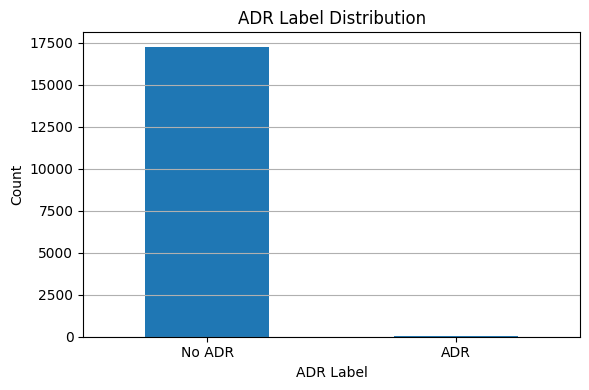

,ICD_9671,ADR,subject_id,hadm_id,icustay_id,window_start,window_end,gender,age,ethnicity,admission_type,ICD_9672,ICD_3995,ICD_4275,ICD_9670,ICD_3965
0,1,0,27513,163557,200003,2199-08-02 19:50:04,2199-08-05 19:50:04,M,48,WHITE,EMERGENCY,0,0,0,0,0
1,1,0,15909,135069,200017,2138-03-17 21:54:36,2138-03-20 21:54:36,M,0,WHITE,NEWBORN,0,0,0,0,0
2,0,0,14987,165426,200030,2150-11-13 14:08:02,2150-11-16 14:08:02,M,54,BLACK/AFRICAN AMERICAN,EMERGENCY,0,0,0,0,0
3,0,0,56369,198650,200033,2198-08-07 17:56:17,2198-08-10 17:56:17,M,67,WHITE,EMERGENCY,1,0,0,0,0
4,0,0,21695,150812,200037,2141-08-07 09:29:48,2141-08-10 09:29:48,F,0,WHITE,NEWBORN,0,0,0,0,0


In [ ]:
# Show class distribution to check imbalance
print("\nClass Distribution (ADR Label):")
print(features_df['ADR'].value_counts())
print("\nPercentage:")
print(features_df['ADR'].value_counts(normalize=True) * 100)

# Plot class distribution
plt.figure(figsize=(6, 4))
features_df['ADR'].value_counts().plot(kind='bar')
plt.title('ADR Label Distribution')
plt.xlabel('ADR Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No ADR', 'ADR'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

features_df.head()

In [ ]:
# Add labs/vitals from MIMIC-III (SOFA-related and common ICU features)
# These steps assume access to BigQuery version of MIMIC-III


# Load relevant vitals/labs from first 3 ICU days
vital_lab_query = """
SELECT ce.icustay_id, ce.charttime, ce.itemid, ce.valuenum
FROM `physionet-data.mimiciii_clinical.chartevents` ce
JOIN `physionet-data.mimiciii_clinical.icustays` icu
  ON ce.icustay_id = icu.icustay_id
WHERE ce.itemid IN (211, 220045, 220210, 220277, 220739, 223761, 223762, 227243, 223830)  -- HR, MAP, Temp, RR, SpO2, GCS, etc.
  AND ce.charttime BETWEEN icu.intime AND DATETIME_ADD(icu.intime, INTERVAL 3 DAY)
  AND ce.valuenum IS NOT NULL
"""
vitals_df = client.query(vital_lab_query).to_dataframe()

# Pivot into ICU stay × feature matrix
agg_funcs = ['mean', 'min', 'max', 'std']
vital_features = vitals_df.pivot_table(
    index='icustay_id',
    columns='itemid',
    values='valuenum',
    aggfunc=agg_funcs
)

# Flatten multi-index columns
vital_features.columns = [f"vital_{itemid}_{stat}" for stat, itemid in vital_features.columns]
vital_features.reset_index(inplace=True)

# Merge vitals into existing feature set
features_df = features_df.merge(vital_features, on='icustay_id', how='left')

# Fill any resulting NaNs in new features
vital_cols = [col for col in features_df.columns if col.startswith("vital_")]
features_df[vital_cols] = features_df[vital_cols].fillna(0)

query_new_meds = """
SELECT
  icu.icustay_id,
  COUNT(DISTINCT p.drug) AS num_new_meds
FROM `physionet-data.mimiciii_clinical.prescriptions` p
JOIN `physionet-data.mimiciii_clinical.icustays` icu
  ON p.hadm_id = icu.hadm_id
WHERE
  p.startdate BETWEEN icu.intime AND DATETIME_ADD(icu.intime, INTERVAL 3 DAY)
GROUP BY icu.icustay_id
"""
new_meds_df = client.query(query_new_meds).to_dataframe()

# 2. Number of medications active in the 3-day window
query_unique_meds = """
SELECT
  icu.icustay_id,
  COUNT(DISTINCT p.drug) AS num_unique_meds
FROM `physionet-data.mimiciii_clinical.prescriptions` p
JOIN `physionet-data.mimiciii_clinical.icustays` icu
  ON p.hadm_id = icu.hadm_id
WHERE
  (p.startdate <= DATETIME_ADD(icu.intime, INTERVAL 3 DAY) OR p.startdate IS NULL)
  AND (p.enddate >= icu.intime OR p.enddate IS NULL)
GROUP BY icu.icustay_id
"""
unique_meds_df = client.query(query_unique_meds).to_dataframe()

# 3. Abnormal lab value flags (based on common ADR indicators)
query_labs_continuous = """
SELECT
  icu.icustay_id,
  MAX(IF(LOWER(d.label) LIKE '%ast%', le.valuenum, NULL)) AS max_ast,
  MAX(IF(LOWER(d.label) LIKE '%alt%', le.valuenum, NULL)) AS max_alt,
  MAX(IF(LOWER(d.label) LIKE '%potassium%', le.valuenum, NULL)) AS max_potassium,
  MAX(IF(LOWER(d.label) LIKE '%creatinine%', le.valuenum, NULL)) AS max_creatinine,
  MIN(IF(LOWER(d.label) LIKE '%platelet%', le.valuenum, NULL)) AS min_platelets
FROM `physionet-data.mimiciii_clinical.labevents` le
JOIN `physionet-data.mimiciii_clinical.d_labitems` d
  ON le.itemid = d.itemid
JOIN `physionet-data.mimiciii_clinical.icustays` icu
  ON le.subject_id = icu.subject_id
WHERE
  le.charttime BETWEEN icu.intime AND DATETIME_ADD(icu.intime, INTERVAL 3 DAY)
  AND le.valuenum IS NOT NULL
  AND (
    LOWER(d.label) LIKE '%ast%' OR
    LOWER(d.label) LIKE '%alt%' OR
    LOWER(d.label) LIKE '%potassium%' OR
    LOWER(d.label) LIKE '%creatinine%' OR
    LOWER(d.label) LIKE '%platelet%'
  )
GROUP BY icu.icustay_id
"""
lab_values_df = client.query(query_labs_continuous).to_dataframe()

# --- Merge with main feature set ---
features_df = features_df.merge(new_meds_df, on='icustay_id', how='left')
features_df = features_df.merge(unique_meds_df, on='icustay_id', how='left')
features_df = features_df.merge(lab_values_df, on='icustay_id', how='left')

# Fill any missing values in new columns
features_df.fillna({
    'num_new_meds': 0,
    'num_unique_meds': 0,
    'max_ast': 0,
    'max_alt': 0,
    'max_potassium': 0,
    'max_creatinine': 0,
    'min_platelets': 0,
}, inplace=True)

In [ ]:
features_df.head()
print(f"Shape of features_df: {features_df.shape}")

Shape of features_df: (17277, 59)


Saved to /content/drive/My Drive/Colab Notebooks/mimic_adr_features_new.csv


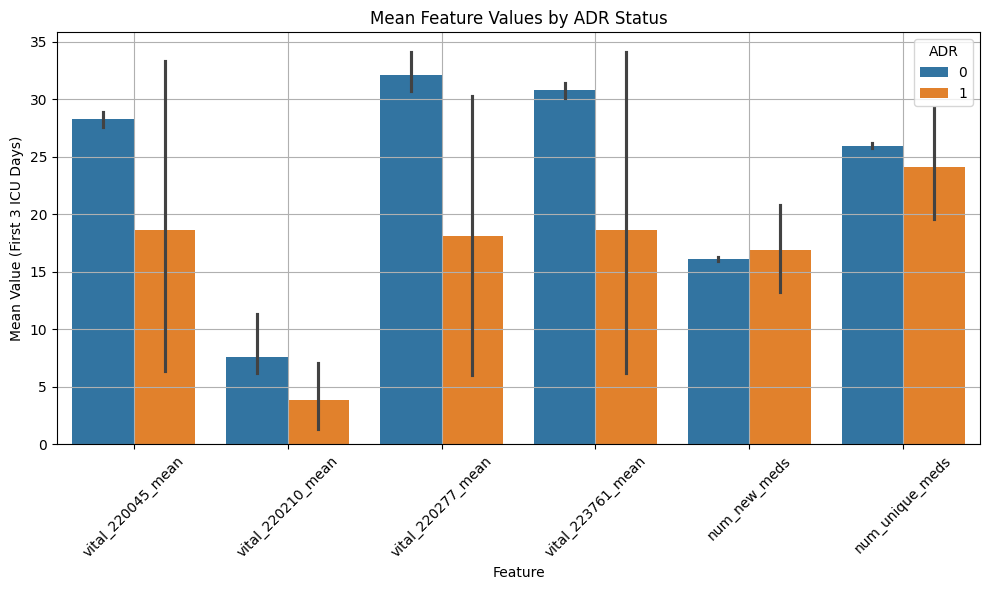

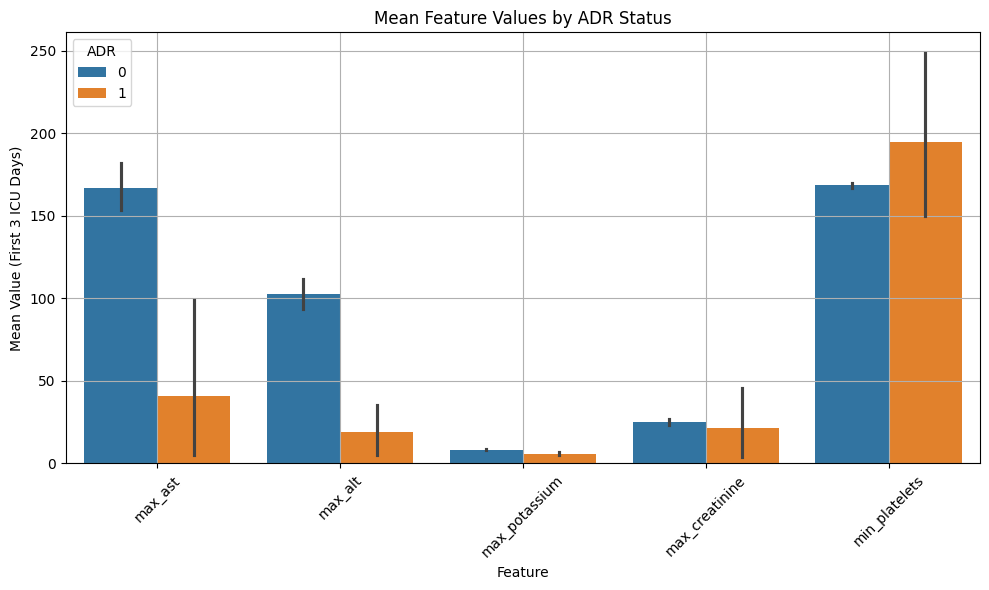

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a few vitals/labs to compare
selected_features = [
    'vital_220045_mean',  # Mean MAP
    'vital_220210_mean',  # Mean Temp
    'vital_220277_mean',  # Mean RR
    'vital_223761_mean',  # Mean GCS
    'num_new_meds',
    'num_unique_meds',
]

# Melt for Seaborn-friendly format
melted = features_df[['ADR'] + selected_features].melt(id_vars='ADR', var_name='Feature', value_name='Value')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Feature', y='Value', hue='ADR')
plt.title("Mean Feature Values by ADR Status")
plt.ylabel("Mean Value (First 3 ICU Days)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Med lab features
labs_features = [
    'max_ast',
    'max_alt',
    'max_potassium',
    'max_creatinine',
    'min_platelets',
                    ]
melted2 = features_df[['ADR'] + labs_features].melt(id_vars='ADR', var_name='Feature', value_name='Value')
plt.figure(figsize=(10, 6))
sns.barplot(data=melted2, x='Feature', y='Value', hue='ADR')
plt.title("Mean Feature Values by ADR Status")
plt.ylabel("Mean Value (First 3 ICU Days)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
features_df[['max_ast', 'max_alt', 'min_platelets']].describe()


,max_ast,max_alt,min_platelets
count,17277.000000,17277.000000,17277.000000
mean,166.908954,102.557504,168.590525
std,1043.860999,631.452476,113.288991
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,89.000000
50%,0.000000,0.000000,156.000000
75%,46.000000,29.000000,232.000000
max,36400.000000,25460.000000,1048.000000


In [ ]:
drive_path = '/content/drive/My Drive/Colab Notebooks/features_with_labs.csv'
features_df.to_csv(drive_path, index=False)
print(f"Saved to {drive_path}")

Saved to /content/drive/My Drive/Colab Notebooks/features_with_labs.csv


In [ ]:
# 1. Count total procedures per admission
procedure_counts = client.query("""
    SELECT
        subject_id,
        hadm_id,
        COUNT(*) AS num_procedures
    FROM `physionet-data.mimiciii_clinical.procedures_icd`
    GROUP BY subject_id, hadm_id
""").to_dataframe()

# Ensure types match
for col in ['subject_id', 'hadm_id']:
    procedure_counts[col] = procedure_counts[col].astype(int)
    features_df[col] = features_df[col].astype(int)

# Merge total count
features_df = features_df.merge(procedure_counts, on=['subject_id', 'hadm_id'], how='left')
features_df['num_procedures'] = features_df['num_procedures'].fillna(0).astype(int)

# 2. Define high-risk ICD codes and labels
HIGH_RISK_PROC_CODES = {
    '9670': 'proc_vent_unspecified',
    '9671': 'proc_vent_lt_96h',
    '9672': 'proc_vent_ge_96h',
    '3995': 'proc_hemodialysis',
    '3965': 'proc_ecmo',
    '4275': 'proc_cardiac_arrest'
}

# 3. Extract only procedures with those codes
procedure_flags = procedures[procedures['icd9_code'].isin(HIGH_RISK_PROC_CODES)].copy()
procedure_flags['proc_feature'] = procedure_flags['icd9_code'].map(HIGH_RISK_PROC_CODES)

# 4. Create pivot table of actual observed high-risk procedures
flag_df = (
    procedure_flags
    .groupby(['subject_id', 'hadm_id', 'proc_feature'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# 5. Keep track of which ones were found
present_flags = [col for col in flag_df.columns if col not in ['subject_id', 'hadm_id']]
print("✅ High-risk procedures present in data:", present_flags)

# 6. Merge only the found columns
features_df = features_df.merge(flag_df, on=['subject_id', 'hadm_id'], how='left')

# 7. Only fill NaNs for those that exist
for col in present_flags:
    features_df[col] = features_df[col].fillna(0).astype(int)


MergeError: Passing 'suffixes' which cause duplicate columns {'num_procedures_x'} is not allowed.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List your binary high-risk procedure columns
procedure_flags = [
    'proc_vent_unspecified',
    'proc_vent_lt_96h',
    'proc_vent_ge_96h',
    'proc_hemodialysis',
    'proc_ecmo',
    'proc_cardiac_arrest'
]

# Melt for grouped barplot
melted_proc = features_df[['ADR'] + procedure_flags].melt(id_vars='ADR', var_name='Procedure', value_name='Present')

# Plot proportion with each procedure flag by ADR
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_proc, x='Procedure', y='Present', hue='ADR', estimator=lambda x: sum(x) / len(x))
plt.title("Proportion of Patients with Each High-Risk Procedure")
plt.ylabel("Proportion Present")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=features_df, x='ADR', y='num_procedures')
plt.title("Distribution of Total Procedures by ADR Status")
plt.xlabel("ADR Label")
plt.ylabel("Number of Procedures")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("Mean number of procedures:")
print(features_df.groupby("ADR")["num_procedures"].mean())